In [1]:
%pylab inline
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time
from pykeops.torch import LazyTensor

Populating the interactive namespace from numpy and matplotlib


In [2]:
use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

In [3]:
def KMeans(x, K=10, Niter=10, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = LazyTensor(x[:, None, :])  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = LazyTensor(c[None, :, :])  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0].split('/')[-1]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
data_dir = os.path.join(os.path.abspath('.'), 'data')
image_dataset = ImageFolderWithPaths(data_dir, data_transforms)
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=128, num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [9]:
out = torchvision.utils.make_grid(inputs)

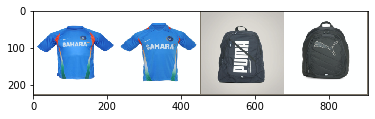

In [10]:
imshow(out)

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
model = nn.Sequential(*list(model_conv.children())[:-1])
for param in model.parameters():
    param.requires_grad = False
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
def get_vector(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    model.to(device)
    return model(image_tensor).reshape(-1).cpu()

In [9]:
img_features = {}

In [10]:
for inputs, _, img_names in iter(dataloader):
    for input_img, img_name in zip(inputs, img_names):
        img_features[img_name] = get_vector(input_img)

In [11]:
images = list(img_features.keys())
features = torch.stack(list(img_features.values()))

In [12]:
cl, c = KMeans(features, 100)

K-means example with 4,135 points in dimension 512, K = 100:
Timing for 10 iterations: 0.76717s = 10 x 0.07672s



In [14]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(vector1.unsqueeze(0), vector2.unsqueeze(0))

In [20]:
import csv
img_clusters = zip(images, list(cl.cpu().numpy()))
with open('img_clusters.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for img_name, cluster in img_clusters:
        csv_writer.writerow([img_name, cluster])

In [13]:
def show_img(img_path):
    img = mpimg.imread('data/products/4929.jpg')
    imgplot = plt.imshow(img)
    plt.show()

In [28]:
cluster_count = {}

In [29]:
import csv

with open('img_clusters.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if str(row[1]) not in cluster_count.keys():
            cluster_count[row[1]] = 0
        cluster_count[row[1]] += 1

In [31]:
whitelisted_clusters = []

In [32]:
for cluster_no in cluster_count.keys():
    if cluster_count[cluster_no] > 10:
        whitelisted_clusters.append(cluster_no)

In [36]:
with open('whitelisted_clusters.txt', 'w') as file:
    for cluster in whitelisted_clusters:
        file.writelines(cluster+'\n')

In [40]:
with open('whitelisted_clusters.txt') as fp:
    for cnt, line in enumerate(fp):
        print(int(line.split('\n')[0]))

91
3
5
9
10
19
21
22
24
25
26
27
31
32
33
34
35
36
39
62
61
44
45
85
93
53
70
56
94
59
64
80
66
67
68
69
71
73
77
78
83
87
86
88
90
92
1
60
99
89
65
76
57
52
47
55
40
54
41
97
84
63
29
98
37
72
51
0
95
20
30
46
12
81
17
15
2
82


In [43]:
features[0]

tensor([7.3357e-01, 2.1347e-01, 7.5980e-02, 3.3068e+00, 5.4323e-02, 6.8978e-01,
        2.9944e-03, 2.5726e+00, 1.7040e+00, 1.1989e-01, 8.2581e-01, 3.8485e-02,
        1.0981e+00, 1.5877e-01, 1.7034e-02, 9.7340e-02, 8.3922e-01, 5.7999e-01,
        5.2556e-03, 8.6980e-03, 5.9744e-01, 8.3688e-01, 1.9243e-01, 3.7728e-01,
        4.3059e-02, 3.3892e-01, 4.0632e-01, 9.8477e-01, 1.0951e-01, 4.4704e-01,
        4.1167e-01, 8.6998e-01, 8.3329e-01, 2.1317e+00, 2.9301e+00, 6.1250e-01,
        9.1811e-01, 1.3946e-02, 7.7360e-01, 1.0948e+00, 1.2348e+00, 1.7328e-01,
        5.4485e-01, 2.5783e-02, 1.1030e+00, 2.8367e-01, 4.1190e-01, 0.0000e+00,
        2.6257e+00, 3.6744e-01, 2.0379e+00, 5.2687e-02, 2.3269e-02, 1.8386e-01,
        3.1404e+00, 7.0924e-01, 3.0461e-01, 4.2643e-01, 1.0657e+00, 8.5452e-01,
        6.8893e-01, 2.8742e-01, 5.7587e-01, 2.1964e+00, 6.6641e-01, 5.5515e-01,
        1.6371e+00, 3.2031e-01, 4.8694e-01, 5.4216e-01, 2.5637e+00, 2.2566e+00,
        9.1611e-02, 2.3366e-01, 1.3514e+

In [50]:
import random
group_of_items = [1, 2, 3, 4]              # a sequence or set will work here.
num_to_select = 5                           # set the number to select here.
list_of_random_items = random.sample(group_of_items, num_to_select)

ValueError: Sample larger than population or is negative

In [49]:
list_of_random_items

[1, 3]